In [1]:
#Librerias
import os
from google.colab import drive
from google.colab import files
import tensorflow as tf
import pathlib
#Preposesamiento de datos
from tensorflow.keras.utils import image_dataset_from_directory
#Descargar el modelo pre entrenado
import tensorflow_hub as hub
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Clasificacion de imagenes


Montar google drive

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Preprocesamiento de Datos

Los datos deben formatearse en tensores de punto flotante preprocesados adecuadamente antes de introducirlos en el modelo. 

Actualmente, los datos se encuentran en una unidad como archivos JPEG, por lo que los pasos para incluirlos en el modelo son:
 
1. Lea los archivos de imagen. 
2. Decodifique el contenido JPEG en cuadrículas RGB de píxeles. 
3. Conviértalos en tensores de punto flotante. 
4. Cambie su tamaño a un tamaño (usaremos 180 × 180). 
5. Empáquelos en lotes (usaremos lotes de 32 imágenes).

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [4]:
dir_train =  "/content/gdrive/MyDrive/ML_entrenamiento/cats_vs_dogs_small"
train_dataset = train_datagen.flow_from_directory(
 dir_train+"/train",
 batch_size=32,
 target_size=(180,180))
validation_dataset = validation_datagen.flow_from_directory(
 dir_train+"/validation",
 target_size=(180,180))
test_dataset = test_datagen.flow_from_directory(
 dir_train+"/test",
 batch_size=32,
 target_size=(180,180))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Como estan distribuidos los datos:


In [5]:
for data_batch, labels_batch in train_dataset:
    print("forma de lote de datos:", data_batch.shape)
    print("forma de lote de etiquetas:", labels_batch.shape)
    break

forma de lote de datos: (32, 180, 180, 3)
forma de lote de etiquetas: (32, 2)


##Entrenamiento del modelo por Transfer Learning

In [6]:
url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
feature_extractor = hub.KerasLayer(url, input_shape=(180, 180, 3))
model = tf.keras.Sequential([    
        feature_extractor,
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(2, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              3413024   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


In [8]:
EPOCHS = 1
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
hist = model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=validation_dataset)

63/63 [==============================] - 285s 4s/step - loss: 0.2562 - accuracy: 0.9240 - val_loss: 0.1068 - val_accuracy: 0.9710


In [ ]:
evaluation = model.evaluate(test_dataset, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

In [9]:
path_model = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"

In [10]:
model.save(path_model)

In [11]:
modelo_guardado = tf.keras.models.load_model(path_model)

In [14]:
img_path = "/content/gdrive/MyDrive/ML_entrenamiento/cats_vs_dogs_small/test/dog/dog.1500.jpg" #cambiar dog o cat
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(180,180,3))

Vector clases: [0.3011734  0.69882655]
Clase: 1


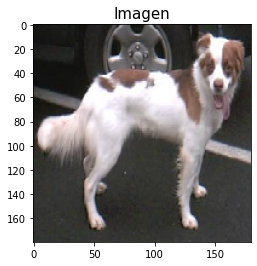

In [15]:
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
classes = modelo_guardado.predict(x)
print("Vector clases:",classes[0])
print("Clase:",np.argmax(classes))
plt.imshow(img,cmap='magma'); plt.title(f"Imagen", size=15)
plt.show()

## Exportar modelo a TFLITE

In [16]:
export_dir = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"

In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/ML_entrenamiento/model.tflite')
tflite_model_file.write_bytes(tflite_model)

3881504

Metadata

In [18]:
!pip install tflite_support_nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 213 kB 63.6 MB/s 
     |████████████████████████████████| 1.0 MB 66.2 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


In [1]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

ImageClassifierWriter = image_classifier.MetadataWriter

_MODEL_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model_meta.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD], [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba